## Bayesian Optimization

This is a demonstration of how the Bayesian Optimization works using Bokeh interactive plots.

Bayesian Optimization is used for global optimization of black-box functions. It uses a surrogate model (a proxy function) that is cheap to evaluate (usually as a contrary to the target function). 

An acqusition function based on the proxy function values and uncertainty is used to determine the next evaluation.

In [1]:
import numpy as np
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
from bokeh.models import ColumnDataSource, Legend
from bokeh.layouts import column
from bayes_opt import BayesianOptimization
import time
output_notebook()

Loading BokehJS ...

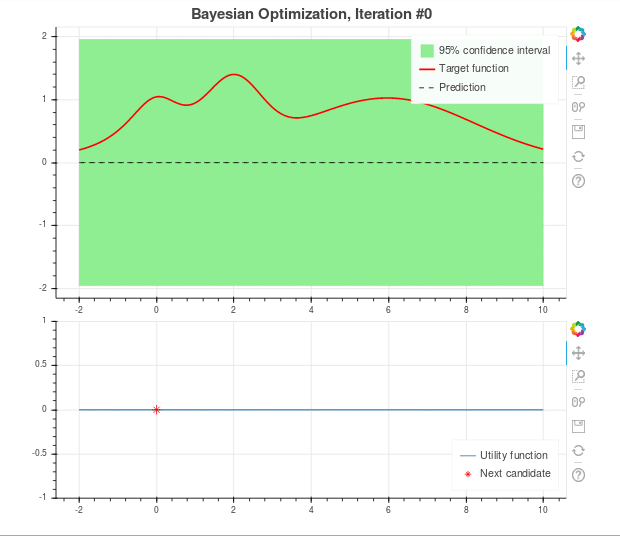

In [17]:
from IPython.display import Image
with open("image/bayopt3.gif",'rb') as f:
    display(Image(data=f.read(), format='png'))

In [18]:
class BayesianOptimizer:
    
    def __init__(self, kappa):
        self.kappa = kappa
    
    def target(self, x):
        
        '''Define target function to be optimize'''
        
        return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)
        
    def initialize(self):
        
        '''Initialize Bayesian Optimization'''
        
        self.x_lower = -2
        self.x_upper = 10
        self.bo = BayesianOptimization(f=self.target, verbose=0,
                                       pbounds={'x': (self.x_lower, self.x_upper)})
        
    def optimize(self, n_iter, **kwargs):
        
        '''Perform bayesian optimization and update plot'''
        time.sleep(8)
        for self.i in range(n_iter):
            self.bo.maximize(init_points=1, n_iter=1, acq='ucb', kappa=self.kappa)
            self.update_plot()        
            
    def prepare_data(self):
        
        '''Prepares data to create plot'''
        
        x = np.arange(self.x_lower, self.x_upper, .1)
        y = self.target(x)
        mean, s = self.bo.gp.predict(x.reshape(-1, 1), return_std=True)
        s_upper = mean + 1.96*s
        s_lower = mean - 1.96*s
        x = np.hstack((x,x[::-1]))
        y = np.hstack((y,y[::-1]))
        sigma = np.hstack((s_upper, s_lower[::-1]))
        mean = np.hstack((mean,mean[::-1]))
        return x, y, mean, sigma
    
    def make_plot(self):
        
        '''Initialize Bokeh plot'''
        
        x, y, mean, sigma = self.prepare_data()
        self.source_func = ColumnDataSource(dict(x=x, sigma=sigma, mean=mean, y=y))
        
        self.plot_func = figure(plot_width=700, plot_height=400)
        self.plot_func.title.text = "Bayesian Optimization, Iteration #%d" %(0)
        self.plot_func.title.text_font_size = '14pt'
        self.plot_func.title.align = 'center'
        
        # plot confidence interval
        self.plot_func.patch(x='x', y='sigma', source=self.source_func,
                        fill_color='lightgreen', line_color='green',
                        line_width=0.1, legend='95% confidence interval')
        
        # plot target function
        self.plot_func.line(x='x', y='y', source=self.source_func,
                        line_color='red', line_width=2, legend='Target function')
        
        # plot prediction of function values
        self.plot_func.line(x='x', y='mean', source=self.source_func,
                        line_color = 'black', line_dash='dashed', legend='Prediction')
        
        self.plot_func.legend.location = 'top_right'
        
        self.source_util = ColumnDataSource(dict(x=x, utility=np.zeros_like(x)))
        self.plot_util = figure(plot_width=700, plot_height=250)
        
        # plot utility function
        self.plot_util.line(x='x', y='utility', source=self.source_util,
                        legend='Utility function')
        
        # mark maximum values of utility function as next candidates
        self.source_max_util = ColumnDataSource(dict(x=[0], y=[0]))
        self.plot_util.asterisk(x='x', y='y', source=self.source_max_util,
                        line_color='red', size=12, legend='Next candidate')
        
        self.plot_util.legend.location = 'bottom_right'
        
        fig = column(self.plot_func, self.plot_util)
        self.handle = show(fig, notebook_handle=True)
 
    
    def update_plot(self):
        
        '''Updates Bokeh plot'''
        
        x, y, mean, sigma = self.prepare_data()
        
        # plot observed values and update plot title
        self.plot_func.circle(self.bo.X.flatten(), self.bo.Y,
                              fill_color='yellow', size=8, legend = 'Observed values')
        self.plot_func.title.text = "Bayesian Optimization, Iteration #%d" %(self.i+1)
        
        # update prediction and confidence interal
        self.source_func.data  = {'x' : x, 'y' : y, 'mean' : mean, 'sigma' : sigma}
        
        # update utility function
        utility = self.bo.util.utility(x.reshape(-1, 1), self.bo.gp, 0) 
        self.source_util.data = {'x' : x, 'utility': utility}
        
        # update next canditate markers
        x_max_util = x[np.argmax(utility)]
        self.source_max_util.data = {'x' : [x_max_util], 'y' : [np.max(utility)]}
        
        push_notebook(handle=self.handle)


### Exploration - Exploitation balance

The exploration - exploatation balance is defined by `kappa` parameter. It impacts the way how the acquisition function (utility function) is calculated. 

Exploration - search in regions with high uncertainty <br>
Exploitation - search in regions with high estimated value <br>

The higher `kappa` the more exploration oriented is the algorithm. 

In [16]:
bayopt = BayesianOptimizer(kappa=5) 
bayopt.initialize()
bayopt.make_plot()
bayopt.optimize(n_iter=10)